In [1]:
import pandas as pd
import numpy as np
 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pymc3 as pm
print(pm.__version__)
import theano.tensor as tt
import patsy

C:\Miniconda3\envs\GLM_with_PyMC3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


3.3


# Reaction Times In A Sleep Deprivation Study
The dataset contains the average reaction time per day for subjects in a sleep deprivation study. On day 0 the subjects had their normal amount of sleep. Starting that night they were restricted to 3 hours of sleep per night. The observations represent the average reaction time on a series of tests given each day to each subject. Data from: https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/lme4/sleepstudy.csv

### Data loading

In [2]:
sleep = pd.read_csv('../datasets/sleepstudy.csv', index_col=0)
sleep['Subject'] = pd.Categorical(sleep['Subject'], ordered=False)
sleep.head(15)

,Reaction,Days,Subject
1,249.5600,0,308
2,258.7047,1,308
3,250.8006,2,308
4,321.4398,3,308
5,356.8519,4,308
6,414.6901,5,308
7,382.2038,6,308
8,290.1486,7,308
9,430.5853,8,308
10,466.3535,9,308


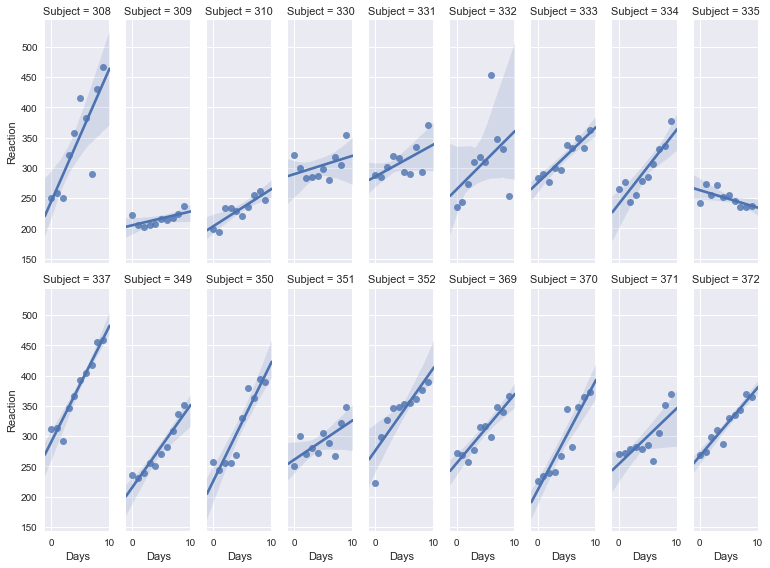

In [56]:
sns.lmplot(x="Days", y="Reaction", col="Subject", data=sleep, col_wrap=9, palette="muted", aspect=0.3, size=4)


## Random effect on the intercepts

In [4]:
X = patsy.dmatrix("1 + Days", data=sleep, return_type='dataframe')
X = np.asarray(X)
X[1:10, :]

array([[1., 1.],
       [1., 2.],
       [1., 3.],
       [1., 4.],
       [1., 5.],
       [1., 6.],
       [1., 7.],
       [1., 8.],
       [1., 9.]])

In [5]:
# Random effect on the intercepts
Z = patsy.dmatrix('0 + Subject', data=sleep, return_type='dataframe')
Z = np.asarray(Z)
Z

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [6]:
Y = np.asarray(sleep['Reaction'])
Y.mean()

298.50789166666664

In [7]:
with pm.Model() as model:

    #beta_X = pm.Normal('beta_X', mu=0, sd=100, shape=X.shape[1])
    
    beta_X_intercept = pm.Normal('beta_X_intercept', mu=Y.mean(), sd=100)
    beta_X_slope = pm.Normal('beta_X_slope', mu=0, sd=100)
    beta_X = pm.Deterministic('beta_X', tt.stack(beta_X_intercept, beta_X_slope))
    
    estimate_X = pm.math.dot(X, beta_X)

    sigma_Z = pm.HalfNormal('sigma_Z', sd=100)
      
    # Non Centered version
    gamma_Z_offset = pm.Normal('gamma_Z_offset', mu=0, sd=1, shape=Z.shape[1])
    gamma_Z = pm.Deterministic('gamma_Z', gamma_Z_offset * sigma_Z)
    
    estimate_Z = pm.math.dot(Z, gamma_Z)
    
    ## likelihood
    estimate = estimate_X + estimate_Z
    sigma = pm.HalfNormal('sigma', sd=100) # unexplained variability
    y_likelihood = pm.Normal('y_likelihood', mu=estimate, sd=sigma, observed=Y)
    
    trace = pm.sample(draws=5000, chains=4, njobs=2, tune=1500, nuts_kwargs={'target_accept':0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma_log__, gamma_Z_offset, sigma_Z_log__, beta_X_slope, beta_X_intercept]
The number of effective samples is smaller than 25% for some parameters.


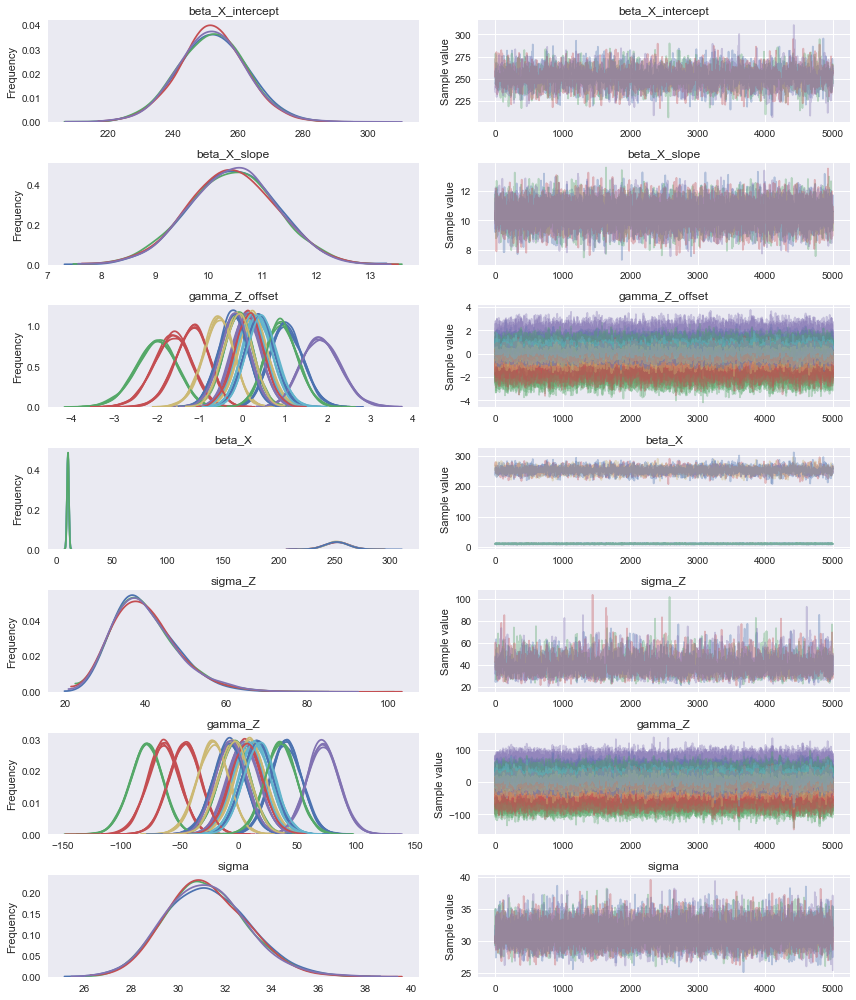

In [8]:
_ = pm.traceplot(trace)

In [9]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_X_intercept,252.082136,10.494791,0.200226,231.668181,273.143491,2954.270411,1.000071
beta_X_slope,10.447438,0.812535,0.007509,8.864268,12.045653,11761.960197,1.000100
gamma_Z_offset__0,1.039925,0.379725,0.005787,0.307551,1.782788,4341.232945,1.000052
gamma_Z_offset__1,-2.026228,0.473606,0.007861,-2.994909,-1.142025,4150.817480,1.000072
gamma_Z_offset__2,-1.647660,0.434066,0.007035,-2.507281,-0.819624,4301.257709,1.000079
gamma_Z_offset__3,0.101290,0.340046,0.005250,-0.557983,0.774138,4870.946603,1.000287
gamma_Z_offset__4,0.251272,0.342572,0.004989,-0.412415,0.943506,4693.660333,1.000073
gamma_Z_offset__5,0.197857,0.343805,0.004865,-0.477450,0.878846,4879.984061,1.000308
gamma_Z_offset__6,0.413713,0.342966,0.005067,-0.247151,1.096620,4826.081033,1.000158
gamma_Z_offset__7,-0.090474,0.339443,0.005204,-0.744404,0.596063,4823.655320,1.000197


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017759965710>,
      dtype=object)

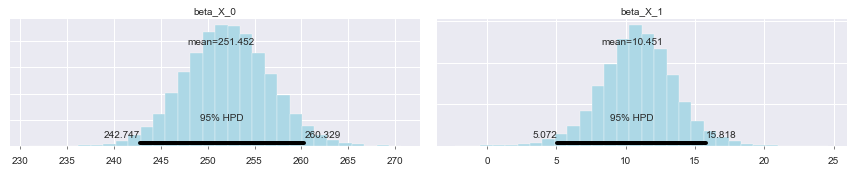

In [65]:
pm.plot_posterior(trace, varnames=['beta_X'], color='#add8e6')

## Random effect on the intercepts and slopes

In [13]:
X = patsy.dmatrix("1 + Days", data=sleep, return_type='dataframe')
X = np.asarray(X)
X[1:10, :]

array([[1., 1.],
       [1., 2.],
       [1., 3.],
       [1., 4.],
       [1., 5.],
       [1., 6.],
       [1., 7.],
       [1., 8.],
       [1., 9.]])

In [14]:
# Random effect on the intercepts and slopes
#Z = patsy.dmatrix('0 + Subject + Subject:Days', data=sleep, return_type='dataframe')
#Z = np.asarray(Z)
#np.all(np.equal(Z, np.concatenate((Z_intercepts, Z_slopes), axis=1)))

Z_intercept = patsy.dmatrix('0 + Subject', data=sleep, return_type='dataframe')
Z_intercept = np.asarray(Z_intercept)

Z_slope = patsy.dmatrix('0 + Subject:Days', data=sleep, return_type='dataframe')
Z_slope = np.asarray(Z_slope)

Z = np.concatenate((Z_intercept, Z_slope), axis=1)

In [15]:
Y = np.asarray(sleep['Reaction'])

In [16]:
with pm.Model() as model:

    #beta_X = pm.Normal('beta_X', mu=0, sd=100, shape=X.shape[1])
    
    beta_X_intercept = pm.Normal('beta_X_intercept', mu=Y.mean(), sd=100)
    beta_X_slope = pm.Normal('beta_X_slope', mu=0, sd=100)
    beta_X = pm.Deterministic('beta_X', tt.stack(beta_X_intercept, beta_X_slope))
    
    estimate_X = pm.math.dot(X, beta_X)

    sigma_Z = pm.HalfNormal('sigma_Z', sd=100)
      
    # Non Centered version
    #gamma_Z_offset = pm.Normal('gamma_Z_offset', mu=0, sd=1, shape=Z.shape[1])
    #gamma_Z = pm.Deterministic('gamma_Z', gamma_Z_offset * sigma_Z)
    #estimate_Z = pm.math.dot(Z, gamma_Z)
    
    gamma_Z_offset_intercept = pm.Normal('gamma_Z_offset_intercept', mu=0, sd=5, shape=Z_intercept.shape[1])
    gamma_Z_intercept = pm.Deterministic('gamma_Z_intercept', gamma_Z_offset_intercept * sigma_Z)
    
    gamma_Z_offset_slope = pm.Normal('gamma_Z_offset_slope', mu=0, sd=5, shape=Z_slope.shape[1])
    gamma_Z_slope = pm.Deterministic('gamma_Z_slope', gamma_Z_offset_slope * sigma_Z)
    
    estimate_Z = pm.math.dot(Z_intercept, gamma_Z_intercept) + pm.math.dot(Z_slope, gamma_Z_slope) 
    
    ## likelihood
    estimate = estimate_X + estimate_Z
    sigma = pm.HalfNormal('sigma', sd=100) # unexplained variability
    y_likelihood = pm.Normal('y_likelihood', mu=estimate, sd=sigma, observed=Y)
    
    trace = pm.sample(draws=5000, chains=4, njobs=2, tune=1500, nuts_kwargs={'target_accept':0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma_log__, gamma_Z_offset_slope, gamma_Z_offset_intercept, sigma_Z_log__, beta_X_slope, beta_X_intercept]
The number of effective samples is smaller than 25% for some parameters.


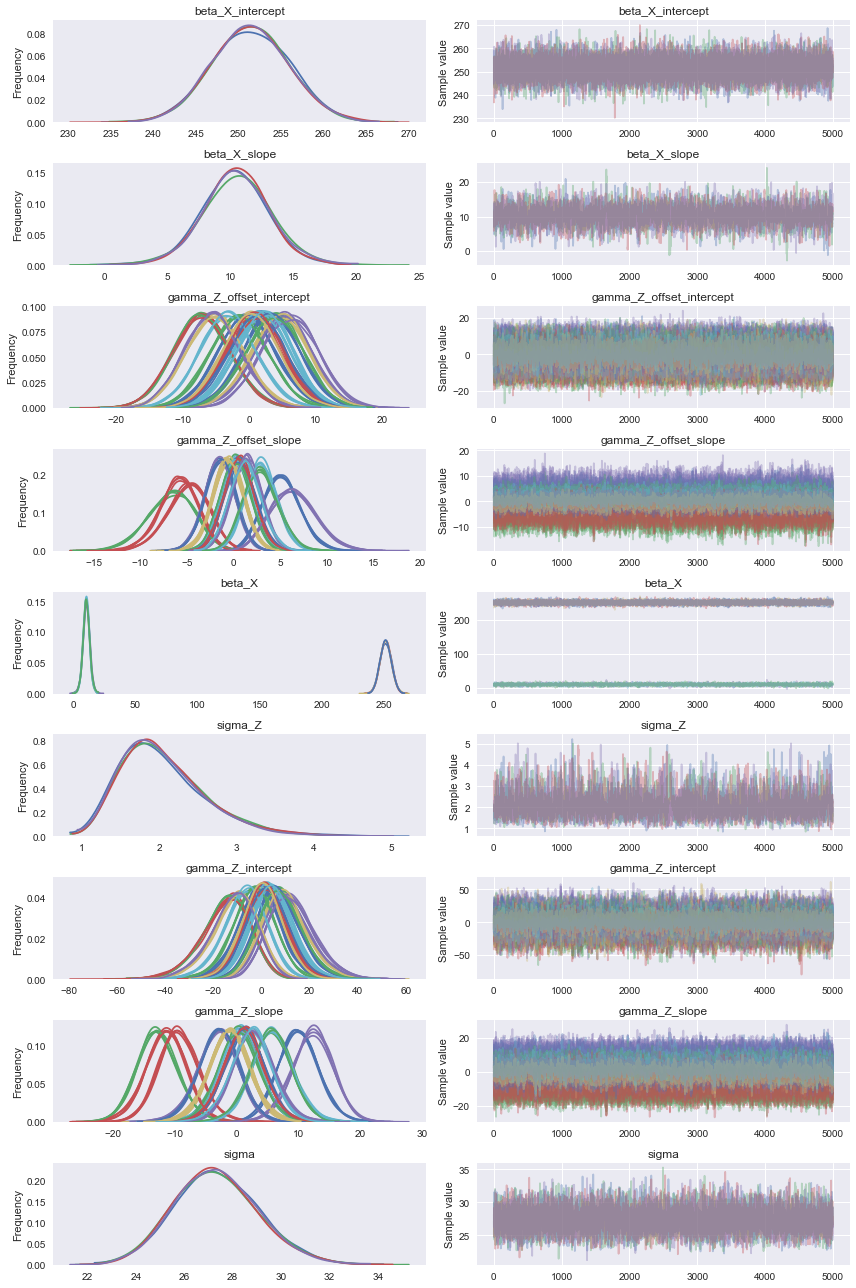

In [17]:
_ = pm.traceplot(trace)

In [18]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_X_intercept,251.451733,4.498173,0.039012,242.746864,260.328717,16368.458161,0.999941
beta_X_slope,10.450860,2.670297,0.045041,5.071611,15.818199,3245.562207,1.001080
gamma_Z_offset_intercept__0,-0.383420,4.271938,0.028416,-8.522276,8.212248,25207.646147,1.000096
gamma_Z_offset_intercept__1,-7.089391,4.242799,0.026200,-15.003957,1.690253,21860.510162,1.000104
gamma_Z_offset_intercept__2,-7.051778,4.241906,0.028315,-15.472504,1.146742,18988.889224,0.999923
gamma_Z_offset_intercept__3,5.043318,4.269709,0.032980,-3.328132,13.498545,20396.171764,0.999943
gamma_Z_offset_intercept__4,4.621926,4.283378,0.031349,-3.416671,13.402824,19965.477416,1.000114
gamma_Z_offset_intercept__5,1.804424,4.178228,0.027500,-6.553307,9.852238,21634.012873,0.999929
gamma_Z_offset_intercept__6,3.323804,4.212331,0.029756,-4.974060,11.611703,23682.730421,1.000035
gamma_Z_offset_intercept__7,-1.505590,4.293731,0.029943,-9.762582,7.078020,23787.164341,1.000041


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017758FF8F60>,
      dtype=object)

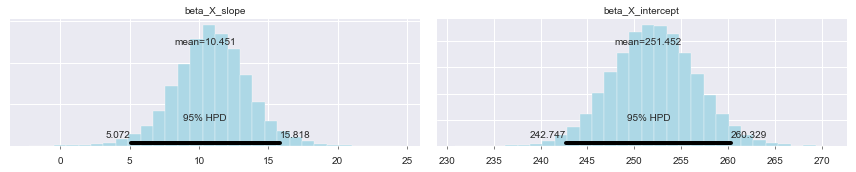

In [59]:
pm.plot_posterior(trace, varnames=['beta_X_slope', 'beta_X_intercept'], color='#add8e6')

In [20]:
trace_df = pm.trace_to_dataframe(trace)
trace_df.head()

,beta_X_intercept,beta_X_slope,gamma_Z_offset_intercept__0,gamma_Z_offset_intercept__1,gamma_Z_offset_intercept__2,gamma_Z_offset_intercept__3,gamma_Z_offset_intercept__4,gamma_Z_offset_intercept__5,gamma_Z_offset_intercept__6,gamma_Z_offset_intercept__7,...,gamma_Z_slope__9,gamma_Z_slope__10,gamma_Z_slope__11,gamma_Z_slope__12,gamma_Z_slope__13,gamma_Z_slope__14,gamma_Z_slope__15,gamma_Z_slope__16,gamma_Z_slope__17,sigma
0,259.037384,4.965923,-0.850530,-9.550615,-19.508815,6.877784,-4.122411,5.323850,5.255174,-5.491581,...,16.196091,7.654652,8.000880,3.661448,10.344566,2.448311,10.527422,1.488926,8.552954,28.219712
1,244.504844,5.734810,1.680422,-10.866988,-2.633258,3.778479,7.792436,2.674564,2.124383,4.893494,...,16.066188,6.948723,10.708520,0.244206,11.679549,6.712828,8.844340,7.471061,5.741359,25.454045
2,255.726740,10.181833,-2.956873,-0.895192,-9.782837,8.215480,5.828573,5.415974,4.601769,-6.485833,...,10.230462,-0.573237,5.215772,-1.156004,6.091962,1.009500,2.089393,-1.111613,3.790181,28.651057
3,248.854689,9.850717,-7.451852,-9.259045,-4.269637,10.759183,7.055609,-0.902805,5.140932,-0.230659,...,12.582260,-1.080059,5.334368,-2.350267,6.777046,1.996292,-0.226942,-2.446360,4.805654,24.679421
4,249.705329,10.615952,9.148590,-2.996500,-6.620760,-6.172646,-3.716158,1.932054,-0.593243,-0.325823,...,15.042980,1.696143,4.969043,-2.344292,5.373577,-0.135342,5.462222,-2.172333,-0.235883,31.539473


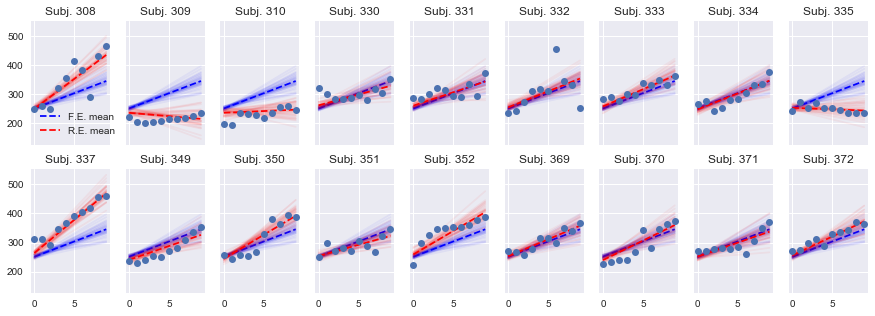

In [66]:
days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    for b0, b1 in zip(trace_df['beta_X_intercept'][::500], 
                      trace_df['beta_X_slope'][::500]):
        ax[i].plot(days, b0 + days*b1, '-b', alpha=0.05)
        ax[i].set_title('Subj. {}'.format(subject))

        
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, trace_df['beta_X_intercept'].mean() + days*trace_df['beta_X_slope'].mean(), '--b',
              label='F.E. mean')
    
# Random effect
for i, subject in enumerate(subject_ids):
    for b0, b1 in zip(trace_df['gamma_Z_intercept__{}'.format(i)][::500], 
                      trace_df['gamma_Z_slope__{}'.format(i)][::500]):
        ax[i].plot(days, trace_df['beta_X_intercept'].mean() + b0 + 
                   days * (trace_df['beta_X_slope'].mean() + b1), '-r', alpha=0.05)

for i, subject in enumerate(subject_ids):
    ax[i].plot(days,
               trace_df['beta_X_intercept'].mean() + trace_df['gamma_Z_intercept__{}'.format(i)].mean() + 
               days * (trace_df['beta_X_slope'].mean() + trace_df['gamma_Z_slope__{}'.format(i)].mean()), '--r', 
               label='R.E. mean')    
    

for i, subject in enumerate(subject_ids):
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    

ax[0].legend()